In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact


In [2]:
df = pd.read_csv("Obesity_trainSet.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [4]:
# Check for Multicolinearity, dropping the Weight the dependent variable
corr = df.select_dtypes("number").corr()
corr

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
id,1.000000,0.007634,0.012041,0.014020,0.002098,-0.000332,0.007917,0.016719,0.007667
Age,0.007634,1.000000,-0.011713,0.283381,0.034414,-0.048479,-0.016325,-0.192259,-0.296154
Height,0.012041,-0.011713,1.000000,0.416677,-0.071546,0.191383,0.183706,0.295278,0.076433
Weight,0.014020,0.283381,0.416677,1.000000,0.245682,0.095947,0.317914,-0.084845,-0.086471
FCVC,0.002098,0.034414,-0.071546,0.245682,1.000000,0.113349,0.101299,-0.089822,-0.147843
NCP,-0.000332,-0.048479,0.191383,0.095947,0.113349,1.000000,0.080949,0.100871,0.067459
CH2O,0.007917,-0.016325,0.183706,0.317914,0.101299,0.080949,1.000000,0.082932,-0.010654
FAF,0.016719,-0.192259,0.295278,-0.084845,-0.089822,0.100871,0.082932,1.000000,0.021213
TUE,0.007667,-0.296154,0.076433,-0.086471,-0.147843,0.067459,-0.010654,0.021213,1.000000


<Axes: >

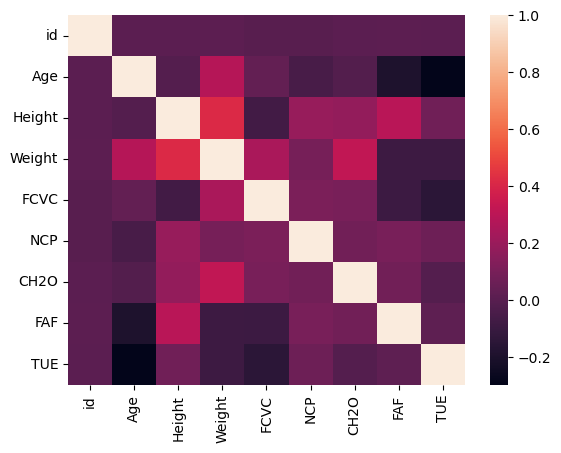

In [5]:
sns.heatmap(corr)

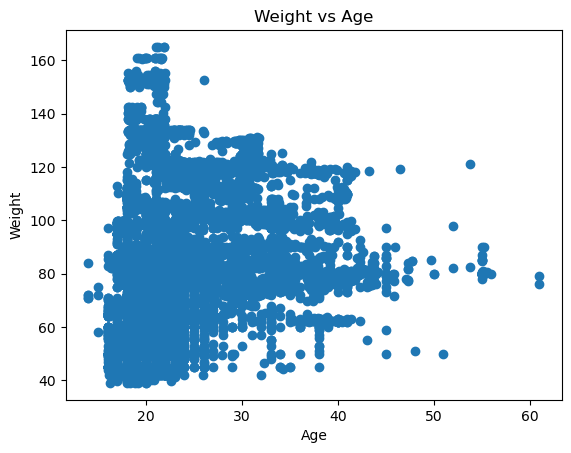

In [6]:
plt.scatter(x=df["Age"], y=df["Weight"])
plt.xlabel("Age")
plt.ylabel("Weight")
plt.title("Weight vs Age");

## SPLIT

Let's separate our features (Consumption of water daily and Physical activity frequency) from our target (Weight).

In [7]:
features = ["CH2O","FAF","CAEC"]
X_train = df[features]

In [8]:
target = "Weight"
y_train = df[target]

## BASELINE MODEL
In other to evaluate our model performance, we a baseline model. The baseline model gives the prediction as the mean of the target variable at every point of the prediction. This is a regression problem where we are predicting the weights of participants, so the first is to fet the mean of the trained (target) data

In [9]:
y_mn = y_train.mean()

In [10]:
baseline_pred = [y_mn]*len(y_train)
baseline_pred[:5]

[87.88776840264958,
 87.88776840264958,
 87.88776840264958,
 87.88776840264958,
 87.88776840264958]

## MEAN ABSOLUTE ERROR

Calculate the baseline mean absolute error for the predictions of the model as compared to the true targets in the trained data.

In [11]:
mae_baseline = mean_absolute_error(y_train, baseline_pred)

print("Mean apt price", round(y_mn, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price 87.89
Baseline MAE: 22.74


This values means that if we are to predict for every weight will be 87.89, we will be off this prediction by 22.74

## PIPELINE
We then create a pipeline to do the linear regression on the trasfromed dataset.


In [12]:
ohe = OneHotEncoder(use_cat_names=True)

model = make_pipeline(
    OneHotEncoder(),
    LinearRegression()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['CAEC'])),
                ('linearregression', LinearRegression())])

Extract the intercept and coefficients for your model

In [13]:
# Assuming `model` is your Pipeline object
last_estimator = model.steps[-1][1]  # Get the last estimator in the pipeline
intercept = last_estimator.intercept_
coefficients = last_estimator.coef_
print("Intercept:", intercept)
print("Coefficients:", coefficients)

Intercept: 1402464563612714.8
Coefficients: [ 1.17039483e+01 -1.76987643e+00 -1.40246456e+15 -1.40246456e+15
 -1.40246456e+15 -1.40246456e+15]


In [14]:
print(
    f"price = {intercept} + ({coefficients[0]}*CH2O) + ({coefficients[1]}*FAF)"
)

price = 1402464563612714.8 + (11.70394834931177*CH2O) + (-1.7698764343628548*FAF)


In [15]:
model_pred = model.predict(X_train)

In [16]:
# Assuming `model` is your Pipeline object
coefficients = model[-1].coef_
print("Coefficients:", coefficients)
# Assuming `model` is your Pipeline object
feature_names = model[0].get_feature_names_out()
print("Feature Names:", feature_names)


Coefficients: [ 1.17039483e+01 -1.76987643e+00 -1.40246456e+15 -1.40246456e+15
 -1.40246456e+15 -1.40246456e+15]
Feature Names: ['CH2O' 'FAF' 'CAEC_1' 'CAEC_2' 'CAEC_3' 'CAEC_4']


In [17]:
# Extracting feature names from the one-hot encoder
feature_names = model[0].get_feature_names_out()
coefficients = model[-1].coef_ # Extracting coefficients from the last estimator
feature_coefficients = pd.Series(coefficients, index=feature_names, name='Coefficient')
sorted_feature_coefficients = feature_coefficients.abs().sort_values() # Sorting the Series by absolute coefficient values
print(sorted_feature_coefficients)



FAF       1.769876e+00
CH2O      1.170395e+01
CAEC_1    1.402465e+15
CAEC_4    1.402465e+15
CAEC_3    1.402465e+15
CAEC_2    1.402465e+15
Name: Coefficient, dtype: float64


As usal lets calculate the training mean absolute error for your predictions.

In [18]:
mae_training = mean_absolute_error(y_train, model_pred)
print("Training MAE:", round(mae_training, 2))

Training MAE: 18.91


In [19]:
X_test = pd.read_csv("Obesity_testSet.csv")
X_test = X_test[["CH2O","FAF","CAEC"]]
X_test.head()

,CH2O,FAF,CAEC
0,2.825629,0.855400,Sometimes
1,3.000000,1.000000,Sometimes
2,2.621877,0.000000,Sometimes
3,2.786417,0.094851,Sometimes
4,2.653531,0.000000,Sometimes


It looks like our model performs a little better than the baseline.

Let's assess our test performance now. It's important to note that once we've tested our model, we cannot iterate further.

In [20]:
# X_test = pd.read_csv("Obesity_testSet.csv")
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    102.00
1    103.75
2    101.25
3    103.00
4    101.50
dtype: float64

Model Prediction is below

In [21]:
def make_prediction(CH2O, FAF, CAEC):
    data = {
        "CH2O": CH2O,
        "FAF": FAF,
        "CAEC": CAEC,
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Weight of Participant: {prediction}"

In [22]:
make_prediction(2.10, -34.60, "Sometimes")

'Weight of Participant: 156.25'

INTERACTIVE DASHBOARD DEPLOYMENT

The model prediction was deployed by creating an interactive dashboard where a user can provide input and then receive a prediction.

In [23]:
interact(
    make_prediction,
    CH2O=FloatSlider(
        min=X_train["CH2O"].min(),
        max=X_train["CH2O"].max(),
        step=0.01,
        value=X_train["CH2O"].mean(),
    ),
    FAF=FloatSlider(
        min=X_train["FAF"].min(),
        max=X_train["FAF"].max(),
        step=0.01,
        value=X_train["FAF"].mean(),
    ),
    CAEC=Dropdown(options=sorted(X_train["CAEC"].unique())),
);

interactive(children=(FloatSlider(value=2.029418243665093, description='CH2O', max=3.0, min=1.0, step=0.01), F…